In [5]:
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
from scipy.io import loadmat
import loaders
from vsdi_preprocessing import clean_outliers,pca_ica,glm
from pathlib import Path

In [ ]:
datapath = Path('/ceph/imaging1/davide/ATC_Data_preprocessed')
atc = loadmat(datapath.joinpath('A04/Day1/ATC1.mat'))
vsdi = loadmat(datapath.joinpath('A04/Day1/vsdi_ATC1.mat'))['vsdi_data']
mask = loadmat(datapath.joinpath(f'A04/Day1/vsdi_mask.mat'))['mask']


In [3]:
vsdi.shape

(94, 54, 29999)

In [7]:
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def pca_ica(vsdi,mask):
    X = vsdi.transpose(2, 0, 1)
    X = X*mask
    X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

    # Create a pipeline with PCA and ICA
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=10)),
        ('ica', FastICA(n_components=10, max_iter=200,
                        random_state=1, whiten='unit-variance'))
    ])

    out = pipe.fit(X)

    fingerprints = out.named_steps["ica"].components_ @ out.named_steps["pca"].components_
    timecourses = fingerprints @ X.T

    return fingerprints,timecourses

clean_vsdi = clean_outliers(vsdi,nsigma=5)



In [23]:
animals = ['A04']
days = ['Day1','Day3','Day5','Day7']

for animal in animals:
    vsdi_total = []
    for day in days:
        vsdi1 = loadmat(datapath.joinpath(f'{animal}/{day}/vsdi_ATC1.mat'))['vsdi_data']
        vsdi2 = loadmat(datapath.joinpath(f'{animal}/{day}/vsdi_ATC2.mat'))['vsdi_data']
        mask = loadmat(datapath.joinpath(f'{animal}/{day}/vsdi_mask.mat'))['mask']

        vsd1 = clean_vsdi(vsdi1,nsigma=5)
        vsdi2 = clean_vsdi(vsdi2,nsigma=5)

        vsdi = np.dstack([vsdi1,vsdi2])
        print(vsdi.shape)
        vsdi_total.append(vsdi1)

vsdi_total = np.dstack(vsdi_total)
print('Done')


TypeError: 'numpy.ndarray' object is not callable

In [ ]:
pca_ica(vsdi_total,mask)

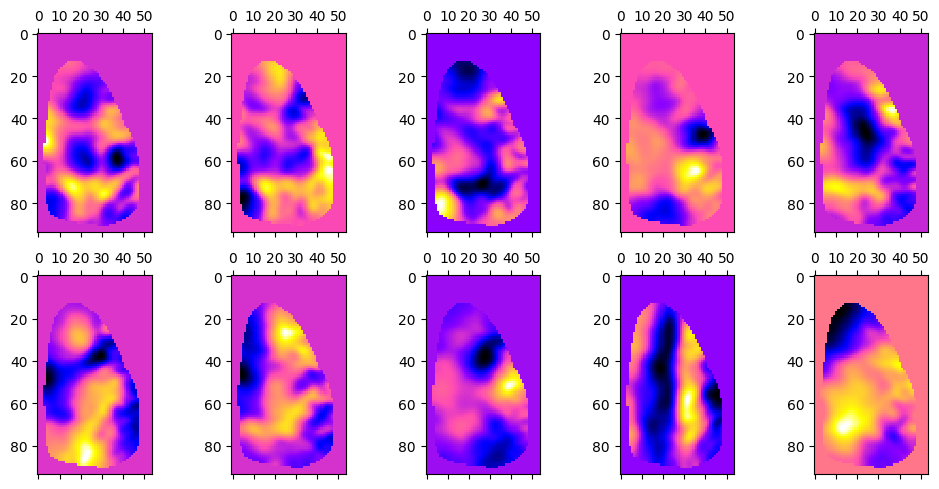

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for i,f in enumerate(fingerprints):
    ax = plt.subplot(2,5,i+1)
    ax.matshow(f.reshape(vsdi.shape[:2]),cmap=plt.cm.gnuplot2)
plt.tight_layout()


# Match masks

In [ ]:
# Mask clustering

In [33]:
from itertools import product

animals = ['A04','A06','A07','A08']
days = ['Day1','Day3','Day5','Day7']

masks = []
for animal,day in product(animals,days):
    try:
        mask = loadmat(datapath.joinpath(f'{animal}/{day}/vsdi_mask.mat'))['mask']
        masks.append(mask)

    except FileNotFoundError:
        print(f"Not found mask for {animal},{day}")
        masks.append(np.nan)
        continue
    except OSError:
        print(f"OS error for {animal},{day}")
        masks.append(np.nan)
        continue
    


In [38]:
len(masks)

16

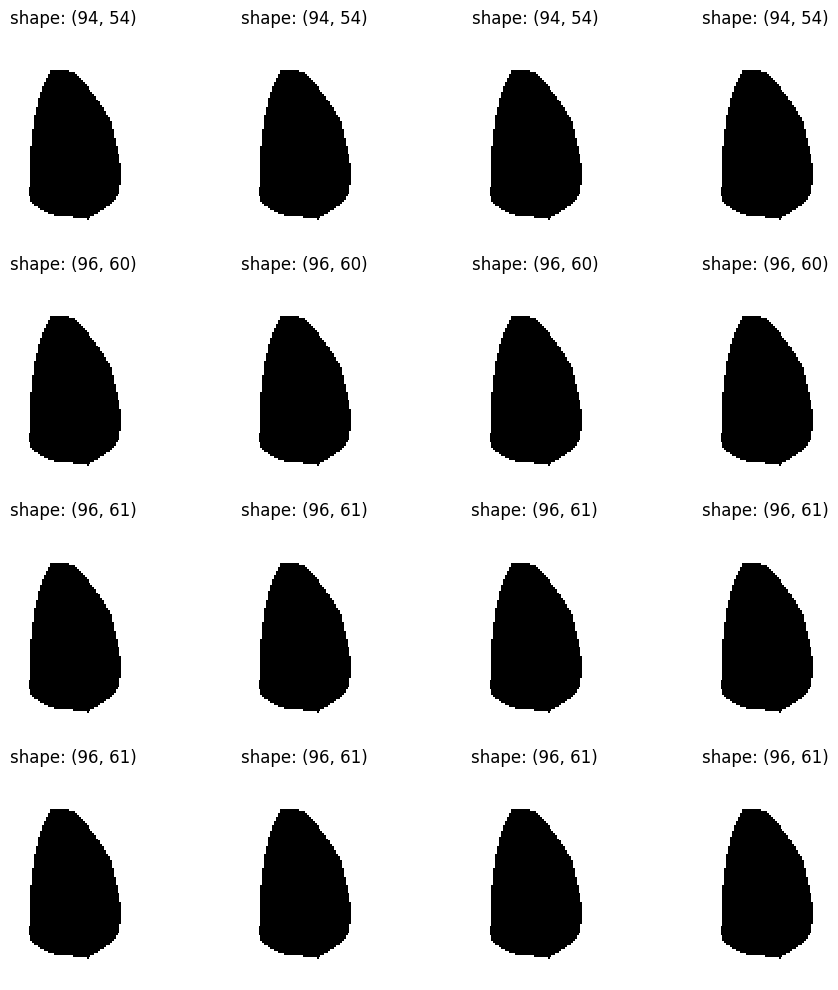

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i,m in enumerate(masks):
    ax = plt.subplot(4,4,i+1)
    ax.matshow(mask,cmap=plt.cm.Greys)
    plt.axis('off')
    plt.title(f'shape: {m.shape}')

plt.tight_layout()


In [89]:
from functools import reduce
def max_common_intersection(mask_list):
    min_x = np.min([m.shape[0] for m in mask_list])
    min_y = np.min([m.shape[1] for m in mask_list])

    cropped_masks = []
    for m in masks:
        if m.shape[0]> min_x and m.shape[1]>min_y:
            cropped_masks.append(m[(m.shape[0]-min_x)//2:-(m.shape[0]-min_x)//2,
                       (m.shape[1]-min_y)//2:-(m.shape[1]-min_y)//2])

        elif m.shape[0] == min_x and m.shape[1]>min_y:
            cropped_masks.append(m[:,(m.shape[1]-min_y)//2:-(m.shape[1]-min_y)//2])

        elif m.shape[0]> min_x and m.shape[1]== min_y:
            cropped_masks.append(m[(m.shape[0]-min_x)//2:-(m.shape[0]-min_x)//2,:])

        else:
            cropped_masks.append(m)
            
    # performs elementwise logical and
    intersection = reduce(lambda x, y: np.logical_and(x, y), cropped_masks)


    return intersection

In [90]:
cm = max_common_intersection(masks)

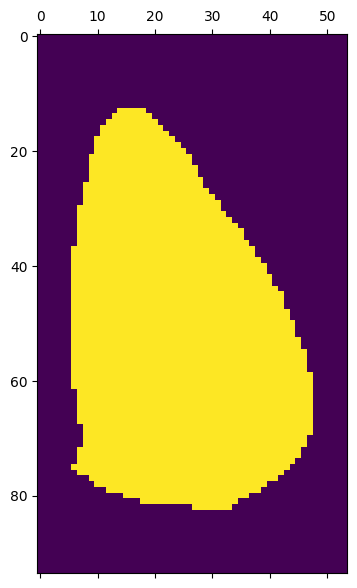

In [91]:
plt.matshow(cm)